### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from src import code_simulator, code

### Parameters

In [2]:
rotation_symmetries = [2, 3, 4]
loss_noise_values = [0.1, 0.05, 0.03, 0.01]
average_photon_numbers = range(1, 4)
number_of_random_code_trials = 80

### Fidelities of Trivial Code

In [3]:
trivial_fidelities = [code_simulator.get_fidelity_of_code_under_loss_noise(code.trivial_code, loss_noise_amount, False) for loss_noise_amount in loss_noise_values]

### Fidelities of Binomial Code

This will take forever to run on the first time because it needs to calculate a lot of stuff, but subsequent runs should be near instantaneous because all the calculation values are saved to files.

In [4]:
%%time

binomial_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), 2))
binomial_photon_numbers = np.zeros((len(rotation_symmetries), len(average_photon_numbers)))
binomial_codes = np.empty((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers))).tolist()
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			binomial_code = code.get_binomial_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
			binomial_codes[i][j][k] = binomial_code
			binomial_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, False)
			binomial_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(binomial_code, loss_noise_amount, True)
			binomial_photon_numbers[i,k] = qt.expect(qt.num(binomial_code.physical_dimension), 1 / 2 * (binomial_code.zero_encoding * binomial_code.zero_encoding.dag() + binomial_code.one_encoding * binomial_code.one_encoding.dag()))

CPU times: user 30.2 ms, sys: 3.88 ms, total: 34.1 ms
Wall time: 33.6 ms


### Fidelities of Cat Code

This will take a bit to run on the first time, but will be near-instantaneous after.

In [5]:
%%time

coherent_state_values = range(1, average_photon_numbers[-1])
cat_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(coherent_state_values), 2))
cat_photon_numbers = np.zeros((len(rotation_symmetries), len(coherent_state_values)))
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, coherent_state_value in enumerate(coherent_state_values):
			cat_code = code.get_cat_code(rotation_symmetry, coherent_state_value, 0, max(int(coherent_state_value ** 2 + 2.2 * coherent_state_value) + 1, rotation_symmetry + 1))
			cat_fidelities[i,j,k,0] = code_simulator.get_fidelity_of_code_under_loss_noise(cat_code, loss_noise_amount, False)
			cat_fidelities[i,j,k,1] = code_simulator.get_fidelity_of_code_under_loss_noise(cat_code, loss_noise_amount, True)
			cat_photon_numbers[i,k] = qt.expect(qt.num(cat_code.physical_dimension), 1 / 2 * (cat_code.zero_encoding * cat_code.zero_encoding.dag() + cat_code.one_encoding * cat_code.one_encoding.dag()))

CPU times: user 19.9 ms, sys: 2.76 ms, total: 22.7 ms
Wall time: 22 ms


### Fidelities of Haar Random Codes

This will probably always take a bit.

In [6]:
%%time

random_fidelities = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials, 2))
random_photon_numbers = np.zeros((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials))
random_codes = np.empty((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers), number_of_random_code_trials)).tolist()
for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		for k, average_photon_number in enumerate(average_photon_numbers):
			for l in range(number_of_random_code_trials):
				random_code = code.make_haar_random_code(rotation_symmetry, average_photon_number, (average_photon_number + 2) * rotation_symmetry)
				random_codes[i][j][k][l] = random_code
				random_fidelities[i,j,k,l,0] = code_simulator.get_fidelity_of_code_under_loss_noise(random_code, loss_noise_amount, False)
				random_fidelities[i,j,k,l,1] = code_simulator.get_fidelity_of_code_under_loss_noise(random_code, loss_noise_amount, True)
				random_photon_numbers[i,j,k,l] = qt.expect(qt.num(random_code.physical_dimension), 1 / 2 * (random_code.zero_encoding * random_code.zero_encoding.dag() + random_code.one_encoding * random_code.one_encoding.dag()))

CPU times: user 9min 52s, sys: 7min 20s, total: 17min 13s
Wall time: 5min 36s


### Plots of Error Rates vs. Average Number

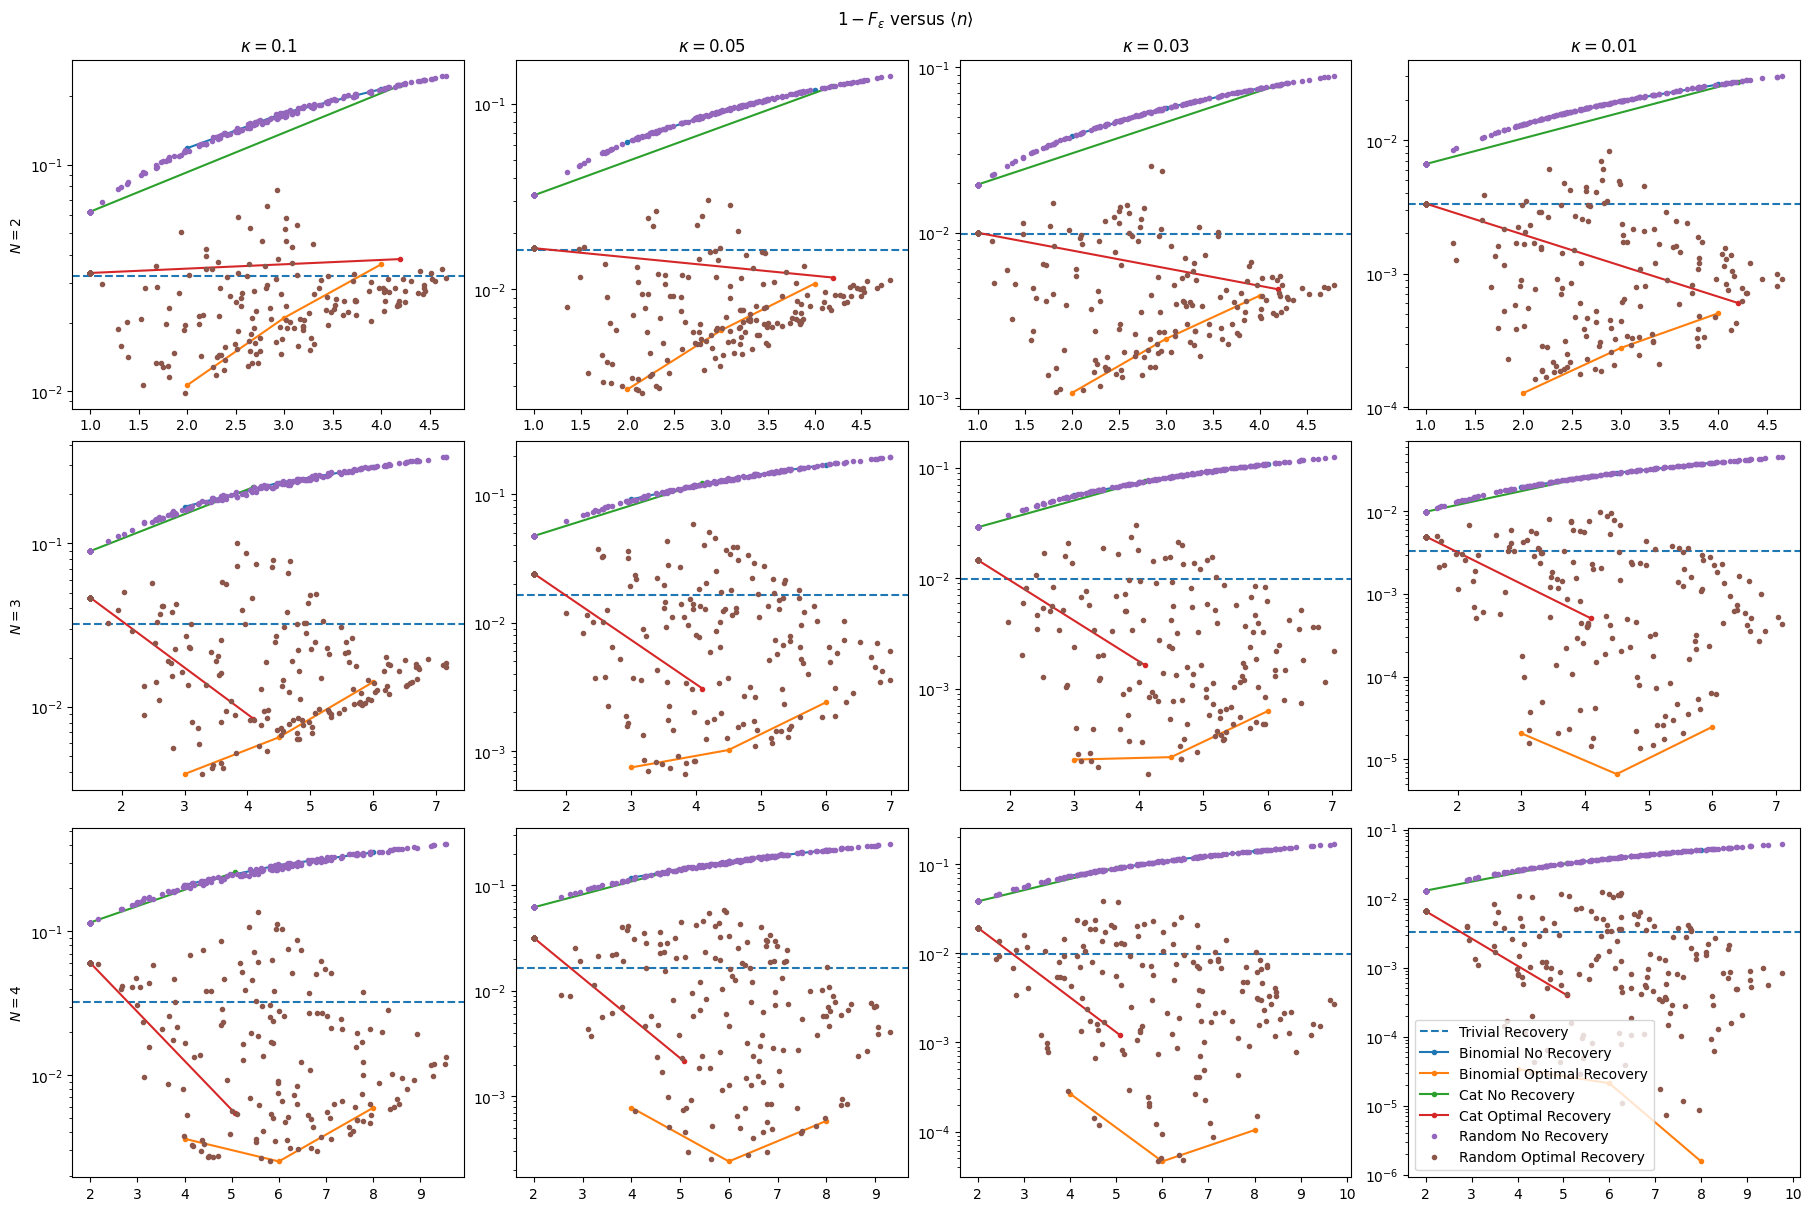

In [7]:
fig, axs = plt.subplots(len(rotation_symmetries), len(loss_noise_values), figsize=(18, 12), constrained_layout=True)
fig.suptitle(r"$1 - F_\epsilon$ versus $\langle n\rangle$")
for i, rotation_symmetry in enumerate(rotation_symmetries):
	axs[i,0].set_ylabel(f"$N={rotation_symmetry}$")
for i, loss_noise_amount in enumerate(loss_noise_values):
	axs[0,i].set_title(f"$\\kappa={loss_noise_amount}$")

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		axs[i,j].axhline(1 - trivial_fidelities[j], linestyle="--", label="Trivial Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,0], ".-", label="Binomial No Recovery")
		axs[i,j].semilogy(binomial_photon_numbers[i], 1 - binomial_fidelities[i,j,:,1], ".-", label="Binomial Optimal Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,0], ".-", label="Cat No Recovery")
		axs[i,j].semilogy(cat_photon_numbers[i], 1 - cat_fidelities[i,j,:,1], ".-", label="Cat Optimal Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,0].flatten(), ".", label="Random No Recovery")
		axs[i,j].semilogy(random_photon_numbers[i,j,:,:].flatten(), 1 - random_fidelities[i,j,:,:,1].flatten(), ".", label="Random Optimal Recovery")

axs[-1,-1].legend()
plt.show()

### Analysis of Optimal Random Codes When Compared Against Optimal Binomial Codes

At $N = 2$ and $\kappa = 0.1$, a random code beat the best binomial code.
Lowest random code error: 0.009798793522963756;	Lowest binomial code error: 0.010617828180579658;	Difference: 0.0008190346576159024
Code similarities: (0.1255054492368615, 0.9140938735146698, 0.3858975867145704, 0.3858975867145704)


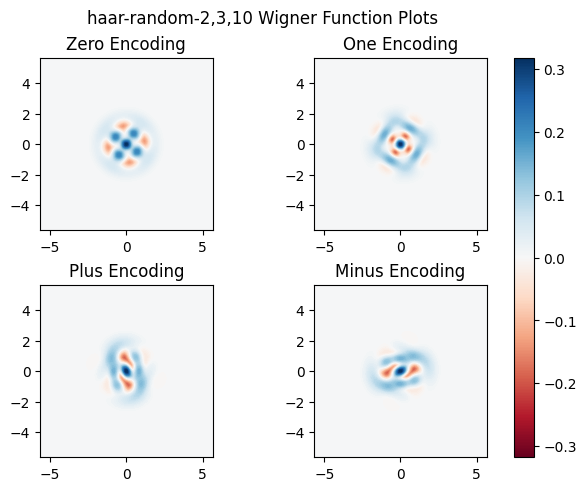

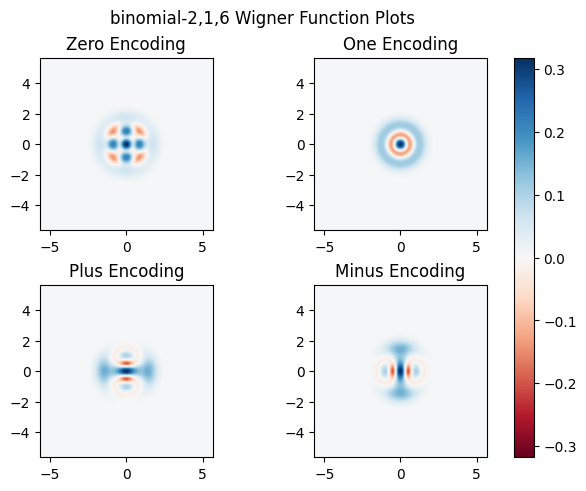

At $N = 2$ and $\kappa = 0.05$, a random code beat the best binomial code.
Lowest random code error: 0.002749649129901166;	Lowest binomial code error: 0.002877823122887535;	Difference: 0.000128173992986369
Code similarities: (0.02738388018584701, 0.941271792199199, 0.24165130806866925, 0.24165130806866925)


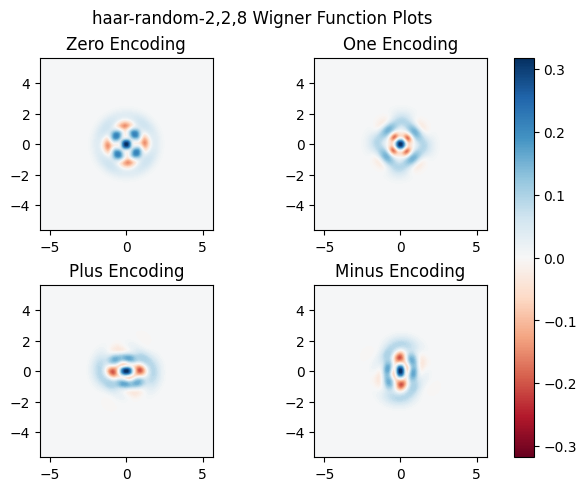

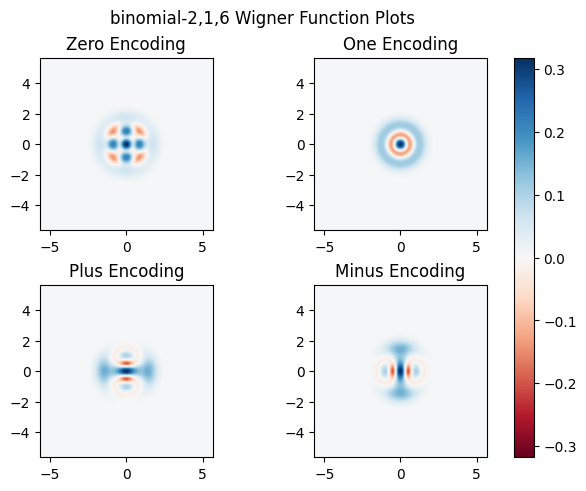

At $N = 3$ and $\kappa = 0.05$, a random code beat the best binomial code.
Lowest random code error: 0.000661823210534429;	Lowest binomial code error: 0.0007457470782491482;	Difference: 8.392386771471916e-05
Code similarities: (0.4713129357060048, 0.8504390048067011, 0.022205974513012164, 0.022205974513012164)


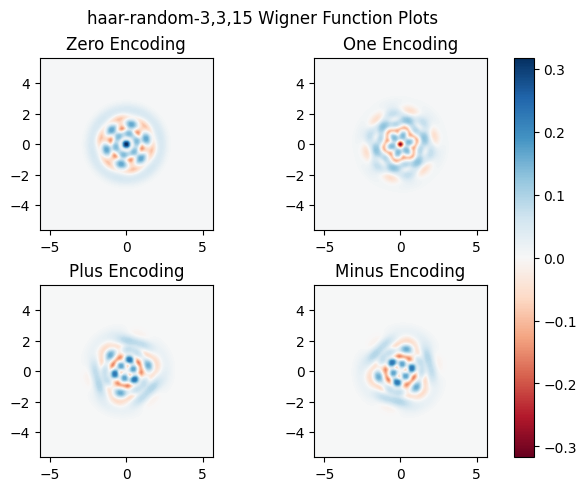

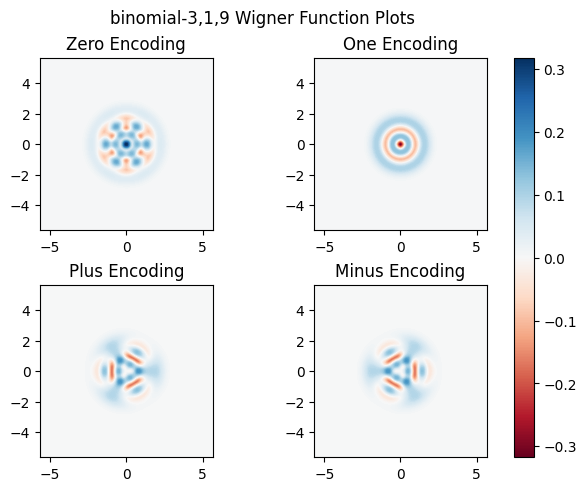

At $N = 3$ and $\kappa = 0.03$, a random code beat the best binomial code.
Lowest random code error: 0.00016875822210360436;	Lowest binomial code error: 0.0002285598787045151;	Difference: 5.9801656600910746e-05
Code similarities: (0.32179781784515477, 0.8093706016488192, 0.12142119199106793, 0.12142119199106793)


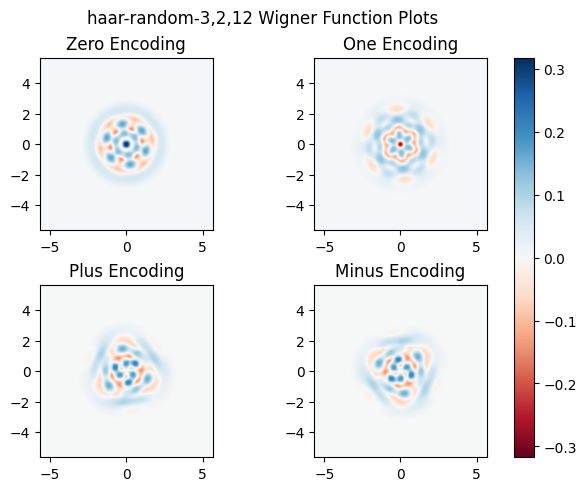

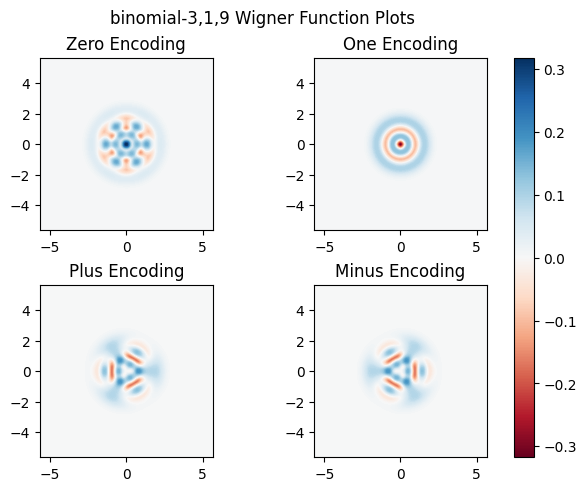

In [8]:
flattened_random_fidelities = random_fidelities.reshape((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers) * number_of_random_code_trials * 2))
flattened_binomial_fidelities = binomial_fidelities.reshape((len(rotation_symmetries), len(loss_noise_values), len(average_photon_numbers) * 2))
best_random_fidelities_in_each_region = np.amax(flattened_random_fidelities, 2)
best_binomial_fidelities_in_each_region = np.amax(flattened_binomial_fidelities, 2)

for i, rotation_symmetry in enumerate(rotation_symmetries):
	for j, loss_noise_amount in enumerate(loss_noise_values):
		random_fidelity_in_region = best_random_fidelities_in_each_region[i,j]
		binomial_fidelity_in_region = best_binomial_fidelities_in_each_region[i,j]
		if random_fidelity_in_region < binomial_fidelity_in_region:
			continue
		random_code_parameter_indices = np.where(random_fidelities[i,j] == random_fidelity_in_region)
		random_code = random_codes[i][j][int(random_code_parameter_indices[0])][int(random_code_parameter_indices[1])]
		code.serialize_code(random_code)
		binomial_code_parameter_indices = np.where(binomial_fidelities[i,j] == binomial_fidelity_in_region)
		binomial_code = binomial_codes[i][j][int(binomial_code_parameter_indices[0])]
		print(f"At $N = {rotation_symmetry}$ and $\\kappa = {loss_noise_amount}$, a random code beat the best binomial code.")
		print(f"Lowest random code error: {1 - random_fidelity_in_region};\tLowest binomial code error: {1 - binomial_fidelity_in_region};\tDifference: {random_fidelity_in_region - binomial_fidelity_in_region}")
		print(f"Code similarities: {code_simulator.compute_code_similarities(random_code, binomial_code)}")
		code_simulator.make_wigner_plots_for(random_code)
		plt.show()
		code_simulator.make_wigner_plots_for(binomial_code)
		plt.show()